In [ ]:
"""
Слои:
1. Conv2d(3, 32, 3) + ReLU + MaxPool2d(2, 2)  # 32x32 -> 16x16
2. Conv2d(32, 64, 3) + ReLU + MaxPool2d(2, 2) # 16x16 -> 8x8  
3. Conv2d(64, 128, 3) + ReLU                  # 8x8 -> 6x6
4. AdaptiveAvgPool2d((4, 4))                  # 6x6 -> 4x4
5. Flatten -> Linear(128*16, 512) + ReLU      # -> 512
6. Dropout(0.5)
7. Linear(512, 10)                            # -> 10 классов
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        
        # Свёрточные слои
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Пулинг
        self.pool = nn.MaxPool2d(2, 2)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Слой 1: Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        
        # Слой 2: Conv -> ReLU -> Pool  
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        
        # Слой 3: Conv -> ReLU
        x = F.relu(self.conv3(x))             # 8x8 -> 6x6
        
        # Адаптивный пулинг до фиксированного размера
        x = F.adaptive_avg_pool2d(x, (4, 4))  # 6x6 -> 4x4
        
        # Преобразование в вектор
        x = x.view(-1, 128 * 4 * 4)
        
        # Полносвязные слои
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [2]:

# Тест модели
model = CIFAR10CNN()
print(model)

# Подсчёт параметров
total_params = sum(p.numel() for p in model.parameters())
print(f"\nОбщее количество параметров: {total_params:,}")

CIFAR10CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Общее количество параметров: 1,147,466


In [4]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# Создание папки для моделей
os.makedirs('models', exist_ok=True)

# Преобразования для данных
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Загрузка датасета
print("Загрузка датасета CIFAR-10...")
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Классы CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Загрузка датасета CIFAR-10...


100%|██████████| 170M/170M [01:05<00:00, 2.59MB/s] 


Используемое устройство: cpu


In [7]:
from tqdm import tqdm

In [8]:
model = CIFAR10CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Метрики для визуализации
train_losses = []
train_accs = []
test_losses = []
test_accs = []

def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(trainloader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'Loss': f'{running_loss/len(trainloader):.3f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    return running_loss/len(trainloader), 100.*correct/total

def test_epoch(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    misclassified_examples = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Сохраняем неправильно классифицированные примеры
            incorrect_indices = predicted != labels
            if incorrect_indices.any():
                for i in range(len(incorrect_indices)):
                    if incorrect_indices[i]:
                        misclassified_examples.append((
                            inputs[i].cpu(),
                            labels[i].cpu(),
                            predicted[i].cpu(),
                            outputs[i].cpu()
                        ))
    
    accuracy = 100. * correct / total
    avg_loss = running_loss / len(testloader)
    
    return avg_loss, accuracy, misclassified_examples[:20]  # Сохраняем первые 20

# Обучение
print("\nНачало обучения...")
best_acc = 0
num_epochs = 15

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)
    
    # Обучение
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    
    # Тестирование
    test_loss, test_acc, misclassified = test_epoch(model, testloader, criterion, device)
    
    # Сохранение метрик
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Обновление learning rate
    scheduler.step()
    
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')
    
    # Сохранение лучшей модели
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': test_acc,
            'epoch': epoch,
        }, 'models/cifar10_model.pth')
        print(f'Новая лучшая модель сохранена! Accuracy: {test_acc:.2f}%')

print(f'\nЛучшая точность на тесте: {best_acc:.2f}%')

# Сохранение истории обучения
np.save('models/train_losses.npy', np.array(train_losses))
np.save('models/train_accs.npy', np.array(train_accs))
np.save('models/test_losses.npy', np.array(test_losses))
np.save('models/test_accs.npy', np.array(test_accs))


Начало обучения...

Epoch 1/15
--------------------------------------------------


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing: 100%|██████████| 79/79 [00:12<00:00,  6.45it/s]


Train Loss: 1.513 | Train Acc: 44.86%
Test Loss: 1.202 | Test Acc: 56.85%
Новая лучшая модель сохранена! Accuracy: 56.85%

Epoch 2/15
--------------------------------------------------


Testing: 100%|██████████| 79/79 [00:12<00:00,  6.24it/s]


Train Loss: 1.135 | Train Acc: 59.46%
Test Loss: 1.029 | Test Acc: 63.10%
Новая лучшая модель сохранена! Accuracy: 63.10%

Epoch 3/15
--------------------------------------------------


Testing: 100%|██████████| 79/79 [00:12<00:00,  6.23it/s]


Train Loss: 0.971 | Train Acc: 65.68%
Test Loss: 0.872 | Test Acc: 69.43%
Новая лучшая модель сохранена! Accuracy: 69.43%

Epoch 4/15
--------------------------------------------------


Testing: 100%|██████████| 79/79 [00:12<00:00,  6.50it/s]


Train Loss: 0.873 | Train Acc: 69.24%
Test Loss: 0.806 | Test Acc: 71.61%
Новая лучшая модель сохранена! Accuracy: 71.61%

Epoch 5/15
--------------------------------------------------


Testing: 100%|██████████| 79/79 [00:11<00:00,  6.87it/s]


Train Loss: 0.813 | Train Acc: 71.50%
Test Loss: 0.731 | Test Acc: 74.83%
Новая лучшая модель сохранена! Accuracy: 74.83%

Epoch 6/15
--------------------------------------------------


Testing: 100%|██████████| 79/79 [00:11<00:00,  6.92it/s]


Train Loss: 0.753 | Train Acc: 73.91%
Test Loss: 0.696 | Test Acc: 75.87%
Новая лучшая модель сохранена! Accuracy: 75.87%

Epoch 7/15
--------------------------------------------------


Testing: 100%|██████████| 79/79 [00:11<00:00,  6.83it/s]


Train Loss: 0.712 | Train Acc: 75.16%
Test Loss: 0.685 | Test Acc: 76.05%
Новая лучшая модель сохранена! Accuracy: 76.05%

Epoch 8/15
--------------------------------------------------


Testing: 100%|██████████| 79/79 [00:11<00:00,  6.99it/s]


Train Loss: 0.674 | Train Acc: 76.23%
Test Loss: 0.682 | Test Acc: 76.33%
Новая лучшая модель сохранена! Accuracy: 76.33%

Epoch 9/15
--------------------------------------------------


Testing: 100%|██████████| 79/79 [00:11<00:00,  6.90it/s]


Train Loss: 0.645 | Train Acc: 77.36%
Test Loss: 0.639 | Test Acc: 78.06%
Новая лучшая модель сохранена! Accuracy: 78.06%

Epoch 10/15
--------------------------------------------------


Testing: 100%|██████████| 79/79 [00:11<00:00,  6.85it/s]


Train Loss: 0.621 | Train Acc: 78.35%
Test Loss: 0.626 | Test Acc: 78.90%
Новая лучшая модель сохранена! Accuracy: 78.90%

Epoch 11/15
--------------------------------------------------


Testing: 100%|██████████| 79/79 [00:11<00:00,  6.90it/s]


Train Loss: 0.527 | Train Acc: 81.77%
Test Loss: 0.576 | Test Acc: 80.88%
Новая лучшая модель сохранена! Accuracy: 80.88%

Epoch 12/15
--------------------------------------------------


Testing: 100%|██████████| 79/79 [00:11<00:00,  6.88it/s]


Train Loss: 0.510 | Train Acc: 82.11%
Test Loss: 0.571 | Test Acc: 80.82%

Epoch 13/15
--------------------------------------------------


Testing: 100%|██████████| 79/79 [00:11<00:00,  6.89it/s]


Train Loss: 0.496 | Train Acc: 82.69%
Test Loss: 0.568 | Test Acc: 81.24%
Новая лучшая модель сохранена! Accuracy: 81.24%

Epoch 14/15
--------------------------------------------------


Testing: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Train Loss: 0.488 | Train Acc: 82.84%
Test Loss: 0.568 | Test Acc: 81.02%

Epoch 15/15
--------------------------------------------------


Testing: 100%|██████████| 79/79 [00:11<00:00,  6.95it/s]

Train Loss: 0.483 | Train Acc: 83.20%
Test Loss: 0.562 | Test Acc: 81.22%

Лучшая точность на тесте: 81.24%


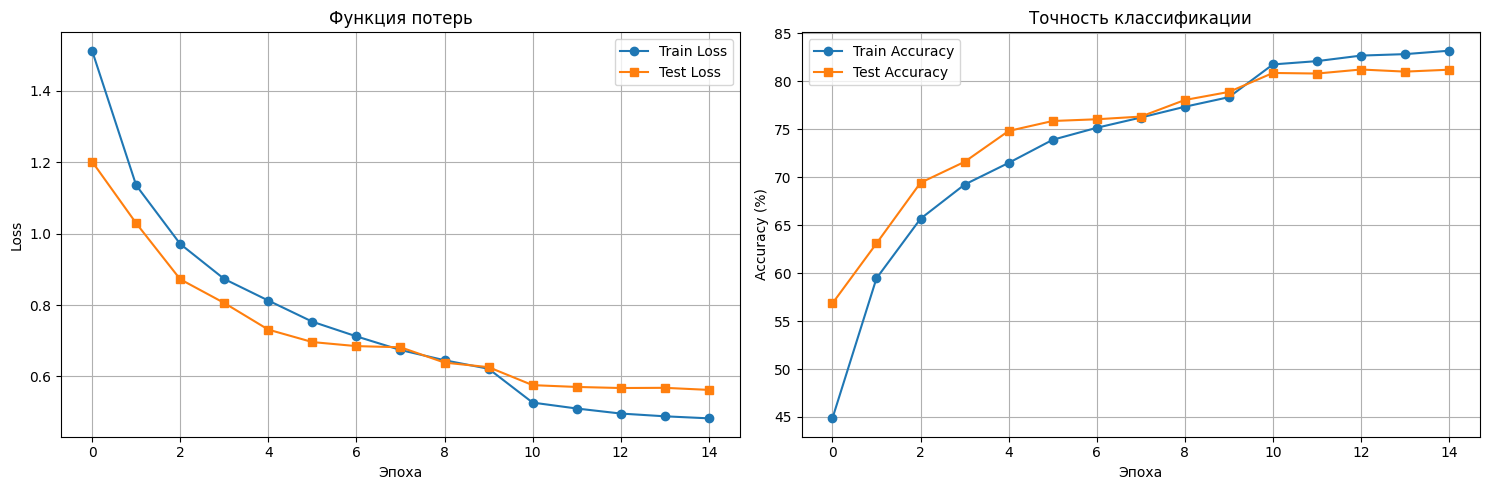

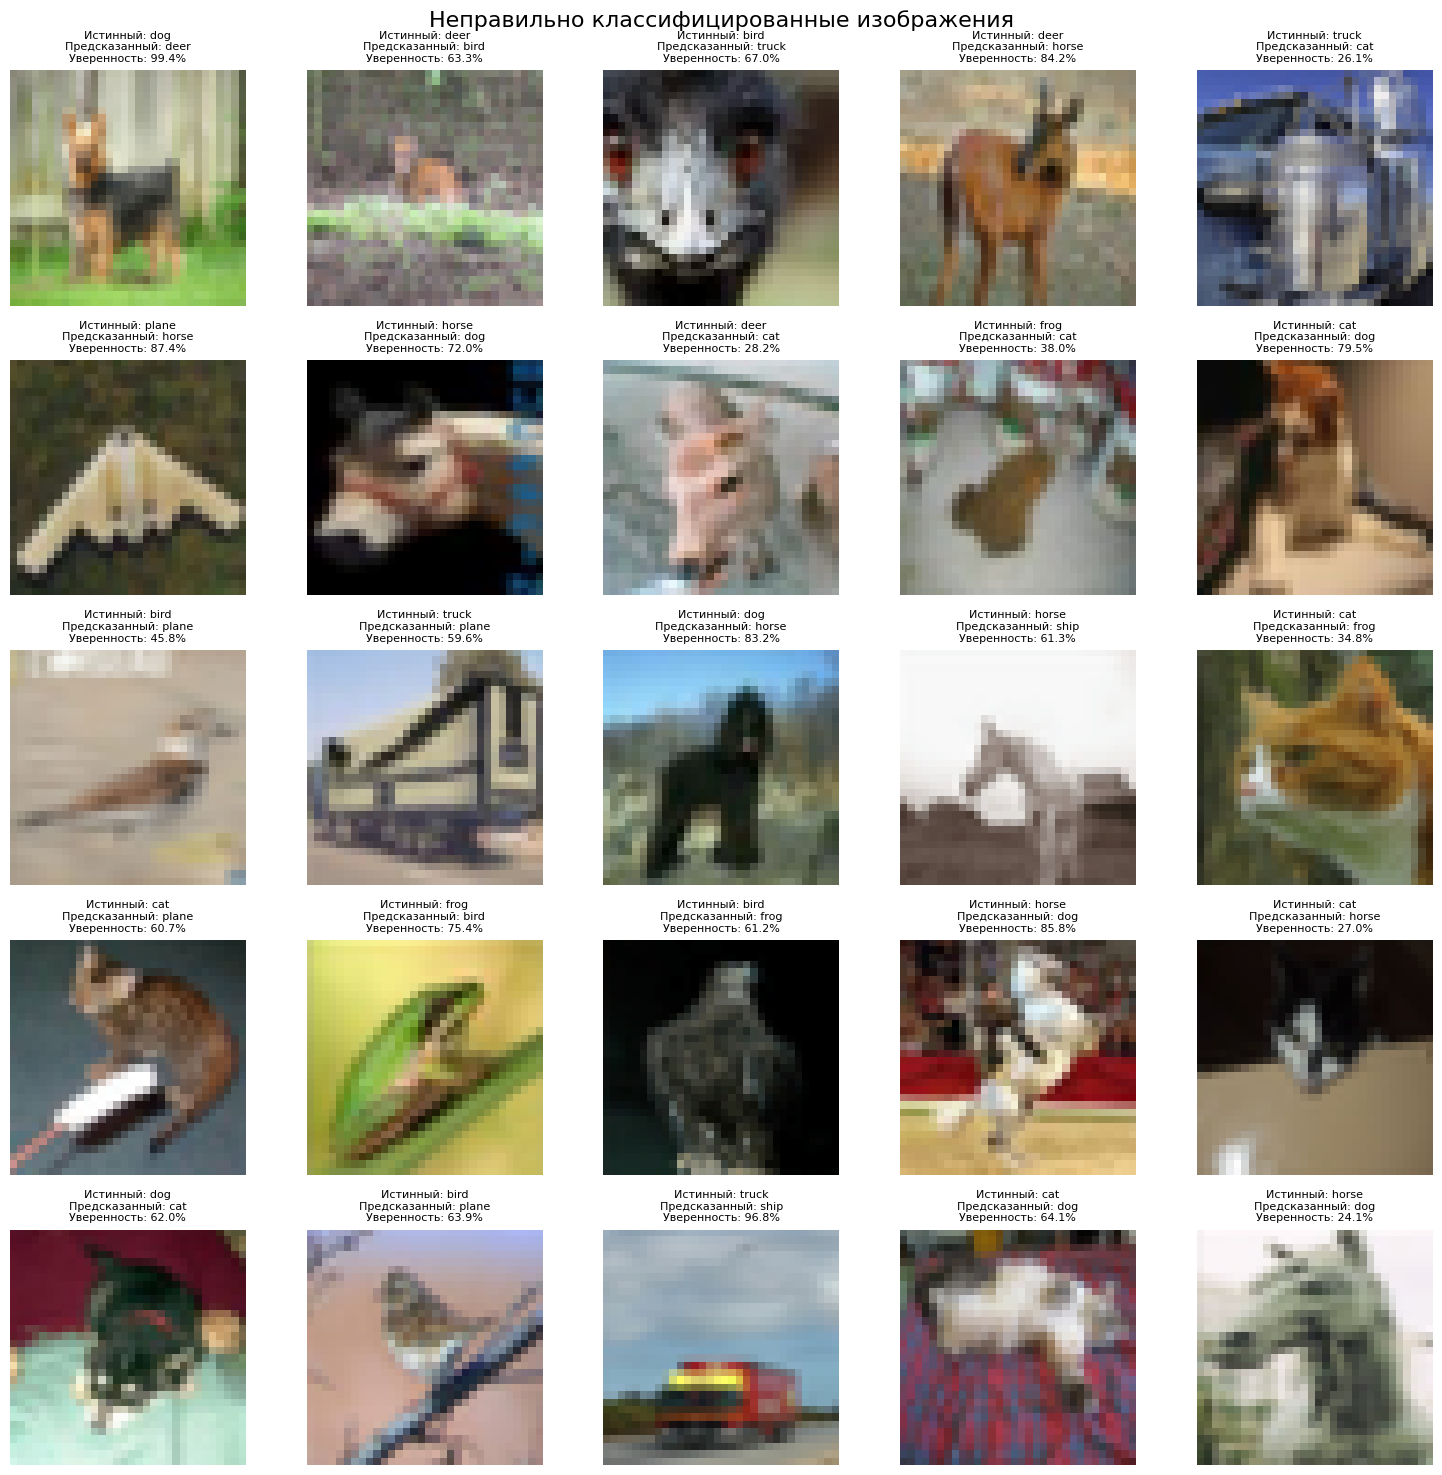

Визуализации сохранены в папке models/
Количество неправильно классифицированных примеров: 25


In [9]:
from torchvision.utils import make_grid
import torchvision.transforms as transforms

# Загрузка метрик
train_losses = np.load('models/train_losses.npy')
train_accs = np.load('models/train_accs.npy')
test_losses = np.load('models/test_losses.npy')
test_accs = np.load('models/test_accs.npy')

# Визуализация метрик обучения
plt.figure(figsize=(15, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='s')
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График точности
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(test_accs, label='Test Accuracy', marker='s')
plt.title('Точность классификации')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('models/training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Загрузка лучшей модели
model = CIFAR10CNN().to(device)
checkpoint = torch.load('models/cifar10_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Получение неправильно классифицированных примеров
misclassified_examples = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        
        incorrect_indices = predicted != labels
        if incorrect_indices.any():
            for i in range(len(incorrect_indices)):
                if incorrect_indices[i]:
                    misclassified_examples.append((
                        inputs[i].cpu(),
                        labels[i].cpu(),
                        predicted[i].cpu(),
                        outputs[i].cpu()
                    ))
        if len(misclassified_examples) >= 25:  # Берем первые 25
            misclassified_examples = misclassified_examples[:25]
            break

# Визуализация неправильно классифицированных изображений
def denormalize(tensor):
    """Денормализация изображения"""
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2023, 0.1994, 0.2010])
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Создание сетки изображений
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle('Неправильно классифицированные изображения', fontsize=16)

for i, (image, true_label, pred_label, outputs) in enumerate(misclassified_examples[:25]):
    row = i // 5
    col = i % 5
    
    # Денормализация и преобразование в numpy
    img = denormalize(image)
    img = np.transpose(img.numpy(), (1, 2, 0))
    img = np.clip(img, 0, 1)
    
    # Вероятности для всех классов
    probs = torch.softmax(outputs, dim=0)
    confidence = torch.max(probs).item() * 100
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Истинный: {classes[true_label]}\n'
                            f'Предсказанный: {classes[pred_label]}\n'
                            f'Уверенность: {confidence:.1f}%',
                            fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('models/misclassified_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print("Визуализации сохранены в папке models/")
print(f"Количество неправильно классифицированных примеров: {len(misclassified_examples)}")